In [75]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from typing import Tuple, Callable, Optional, List
import seaborn as sns
import scipy as sp

import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import stats
from frame_whitening import simulation_new as sim


In [76]:
seed = 42069
np.random.seed(seed)
n, k = 2, 3
batch_size = 32
n_batch = 500
lr_g = 5E-2

V, _ = np.linalg.qr(np.random.randn(n, n))
theta = np.deg2rad(45)
V = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Cxx0 = V @ np.diag([4, 1]) @ V.T * 0.1
Cxx0 *= 50
cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
W = fw.get_mercedes_frame()

g0 = np.array([0.01, 1.2, 0.25])
g, g_all, errors, variances = sim.simulate(cholesky_list, W, batch_size, n_batch, lr_g, g0=g0, online=False, seed=seed)

In [3]:
variances

array([1.00000445, 0.99999123, 1.00001673])

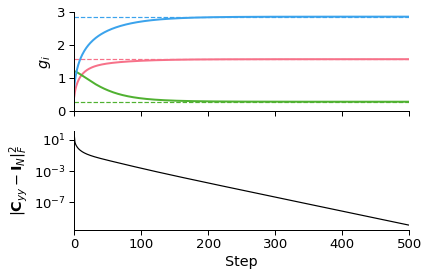

In [77]:
with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex="all")
    g_opt = get_g_opt(W, Cxx0)
    cols = sns.color_palette("husl", 3)
    for i in range(k):
        ax[0].plot(g_all[:,i], color=cols[i], label=f"g{i}", linewidth=2)
        ax[0].axhline(g_opt[i], color=cols[i], linestyle='--')
    ax[0].set(ylabel=r"$g_i$", xlim=(0, n_batch), ylim=(0, 3))
    ax[1].plot(errors, "k")
    ax[1].set(ylabel=r"$\|{\bf C}_{yy} - {\bf I}_N\|_{F}^2$", xlabel="Step", yscale="log")
    sns.despine()

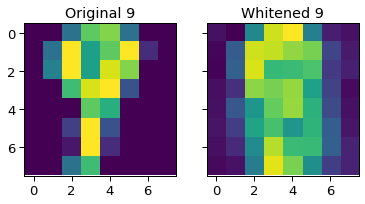

In [67]:
import sklearn.datasets

data = sklearn.datasets.load_digits()

idx = 99
# plt.imshow(data.data[idx].reshape(8, 8))

mu = data.data.mean(0, keepdims=True)
X0 = data.data - mu

I = np.eye(X0.shape[1])
alpha = 0.0001

# whiten X0
Cxx = np.cov(X0.T)
L, V = np.linalg.eigh(Cxx)
L = np.clip(L, 0, np.inf) + alpha

L_inv_sqrt = np.diag(np.sqrt(1 / L))
Mw = V @ L_inv_sqrt @ V.T

X = X0 @ Mw
Cww = np.cov(X.T)

with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex="all", sharey="all")
    idx = 69
    ax[0].imshow(X0[idx].reshape(8, 8) + mu.reshape(8, 8))
    ax[1].imshow(X[idx].reshape(8, 8) + mu.reshape(8, 8))

    ax[0].set(title=f"Original {data.target[idx]}")
    ax[1].set(title=f"Whitened {data.target[idx]}")

# generate grassmannian 64 x 64*(64+1)//2 frame, then run algorithm

W64 = fw.normalize_frame(np.random.randn(64, 64*(64+1)//2))
Lxx = np.linalg.cholesky(alpha * I + Cxx)
g, g_all, errors, variances = simulate([Lxx], W64, batch_size, 5000, .01, g0=None, online=False, seed=seed)

[None]

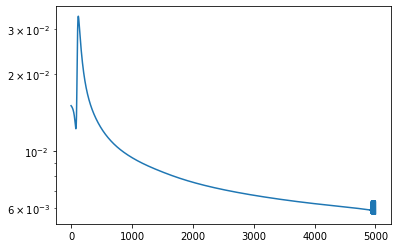

In [68]:
fig, ax = plt.subplots(1, 1)
ax.plot(errors)
ax.set(yscale="log")

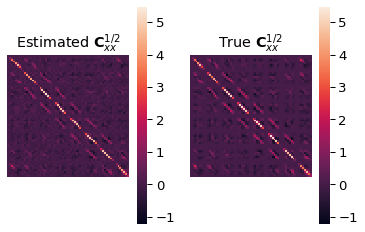

In [74]:
with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 2, sharex="all", sharey="all")
    Cxx12_est = I + W64 @ np.diag(g[-1]) @ W64.T
    Cxx12 = sp.linalg.sqrtm(alpha * I + Cxx)
    Cxx12 = I + W64 @ np.diag(get_g_opt(W64, Cxx)) @ W64.T

    vmin, vmax = np.min([Cxx12, Cxx12_est]), np.max([Cxx12, Cxx12_est])
    sns.heatmap(Cxx12_est, ax=ax[0], square=True, vmin=vmin, vmax=vmax)
    sns.heatmap(Cxx12, ax=ax[1], square=True, vmin=vmin, vmax=vmax)
    ax[0].set(title=r"Estimated ${\bf C}_{xx}^{1/2}$", xticks=[], yticks=[])
    ax[1].set(title=r"True ${\bf C}_{xx}^{1/2}$")